In [4]:
%%time 
!apt update --quiet
!apt upgrade --quiet
# GDAL Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal --quiet
# Install rtree - Geopandas requirment
!apt install python3-rtree --quiet
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet
# Install descartes - Geopandas requirment
!pip install descartes --quiet
# Install Folium for Geographic data visualization
!pip install folium --quiet
# Install Pysal
!pip install pysal --quiet
# Install splot --> pysal
!pip install splot --quiet
# Install mapclassify
!pip install mapclassify --quiet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages

In [ ]:
#import pandas as pd
#import pandas.io.sql as sqlio
#import psycopg2
#import numpy as np
i#mport matplotlib
#import matplotlib.pyplot as plt
#import seaborn as sns
#import missingno
#import folium 
#from folium import plugins
#from folium.plugins import HeatMap
#from geopy.geocoders import Nominatim
#%matplotlib inline

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from pysal.explore import esda
from pysal.lib import weights
#import libysal as lps
#from pysal.viz.splot.esda import plot_moran, plot_local_autocorrelation, lisa_cluster
import matplotlib
import matplotlib.pyplot as plt 

import folium
from folium import plugins
from folium.plugins import HeatMap

import os
import seaborn as sns
#from sklearn.cluster import KMeans
from sklearn.cluster import dbscan

from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster

import pysal as ps
ps.__version__

import missingno
from geopy.geocoders import Nominatim

from geopandas.tools import geocode

In [6]:
%matplotlib inline

In [7]:
username="taxisrcp_user"
password="123123123"
host="ds4ataxisrcp.col3gdd6vsxk.us-east-2.rds.amazonaws.com"
port="5432"
dbname="taxisrcp_db"
try:
    connection = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, password))
    sql = '''select s.id, s.creado fecha, 
              tp.parametro estado, 
              s.tipo_servicio,
              dir.numero directorio,
              direc.direccion_completa direccion,
              direc.latitud,
              direc.longitud,
              b.barrio,
              p.nombres,
              p.genero
            from mastermind_solicitud s 
            inner join parametrizacion_tipoparametro tp on s.status_id = tp.id
            left join administracion_directorio dir on s.directorio_id=dir.id
            left join administracion_perfil p on dir.perfil_id=p.id
            left join administracion_direccion direc on dir.direccion_id = direc.id::integer
            left join administracion_barrio b on direc.barrio_id::integer = b.id'''   
    df = sqlio.read_sql_query(sql, connection)
    #sql = "select * from administracion_directorio"
    #df_directorio = sqlio.read_sql_query(sql, connection)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    #closing database connection.
    if(connection):
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [27]:
df_taxisrcp = pd.DataFrame(df)

In [28]:
df_taxisrcp

,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero
0,1684494,2019-06-15,Confirmada fuera de tiempo,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.286333,Las Margaritas,nan,NaN
1,1684511,2019-06-15,Confirmada,SC,1024,TORRES DE MARILUZ,NaN,NaN,Mariluz III,nan,NaN
2,1684513,2019-06-15,Confirmada fuera de tiempo,SC,7293074,miravalle,NaN,NaN,nan,nan,NaN
3,1684520,2019-06-15,Confirmada fuera de tiempo,SC,3013488266,kr 24 13 54 santiago,NaN,NaN,nan,nan,NaN
4,1684525,2019-06-15,Confirmada fuera de tiempo,SC,1011,KR 35 19 10 HABITAR VERSALLES,NaN,NaN,Versalles,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2436910,1684278,2019-06-15,Confirmada fuera de tiempo,SC,3177203316,CANCHALA,NaN,NaN,nan,nan,NaN
2436911,1684341,2019-06-15,Confirmada fuera de tiempo,SC,3165780828,cra 18 13a 24,NaN,NaN,nan,nan,NaN
2436912,1684398,2019-06-15,Confirmada fuera de tiempo,SC,3013922758,KRA 41 9 25 M/3,NaN,NaN,nan,nan,NaN
2436913,1684449,2019-06-15,Confirmada fuera de tiempo,SC,3015410836,Calle 19 # 17b - 58,NaN,NaN,nan,nan,NaN


In [41]:
df_taxisrcp.info()
df_taxisrcp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2436915 entries, 0 to 2436914
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             int64         
 1   fecha          datetime64[ns]
 2   estado         category      
 3   tipo_servicio  category      
 4   directorio     object        
 5   direccion      object        
 6   latitud        float64       
 7   longitud       float64       
 8   barrio         object        
 9   nombres        object        
 10  genero         category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 155.7+ MB


,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero
0,1684494,2019-06-15,Confirmada fuera de tiempo,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.286333,Las Margaritas,nan,NaN
1,1684511,2019-06-15,Confirmada,SC,1024,TORRES DE MARILUZ,NaN,NaN,Mariluz III,nan,NaN
2,1684513,2019-06-15,Confirmada fuera de tiempo,SC,7293074,miravalle,NaN,NaN,nan,nan,NaN
3,1684520,2019-06-15,Confirmada fuera de tiempo,SC,3013488266,kr 24 13 54 santiago,NaN,NaN,nan,nan,NaN
4,1684525,2019-06-15,Confirmada fuera de tiempo,SC,1011,KR 35 19 10 HABITAR VERSALLES,NaN,NaN,Versalles,nan,NaN


In [10]:
df['estado'].unique()

array(['Confirmada fuera de tiempo', 'Confirmada', 'Generada',
       'Cancelada', 'Activa'], dtype=object)

The output shows that we have around 2.4 million entries with 10 columns. There are some columns with null values. The data type of columns have the same type so we need to to set up the correct data type.

## **Setting the data types correctly**
we will change the data types in the following way:

*   fecha to datatime
*   estado to categorical
*   tipo_servicio to categorical
*   directorio to string
*   direccion to string
*   latitud to numeric
*   longitud to numeric
*   barrio to string
*   nombres to string
*   genero to categorical


In [43]:
df_taxisrcp['fecha'] = pd.to_datetime(df['fecha'])
df_taxisrcp['estado'] = df_taxisrcp['estado'].astype('category')
df_taxisrcp['tipo_servicio'] = df_taxisrcp['tipo_servicio'].astype('category')
df_taxisrcp['directorio'] = df_taxisrcp['directorio'].astype('str')
df_taxisrcp['latitud'] = df_taxisrcp['latitud'].astype('float64')
df_taxisrcp['longitud'] = df_taxisrcp['longitud'].astype('float64')
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].astype('str')
df_taxisrcp['nombres'] = df_taxisrcp['nombres'].astype('str')
df_taxisrcp['genero'] = df_taxisrcp['genero'].astype('category')

In [44]:
df_taxisrcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2436915 entries, 0 to 2436914
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             int64         
 1   fecha          datetime64[ns]
 2   estado         category      
 3   tipo_servicio  category      
 4   directorio     object        
 5   direccion      object        
 6   latitud        float64       
 7   longitud       float64       
 8   barrio         object        
 9   nombres        object        
 10  genero         category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 155.7+ MB


# **Missing values and Duplicated Entries**

In [45]:
df_taxisrcp.isna().sum()

id                     0
fecha                  0
estado                 0
tipo_servicio          0
directorio             0
direccion           2064
latitud          1897029
longitud         1897029
barrio                 0
nombres                0
genero           2433075
dtype: int64

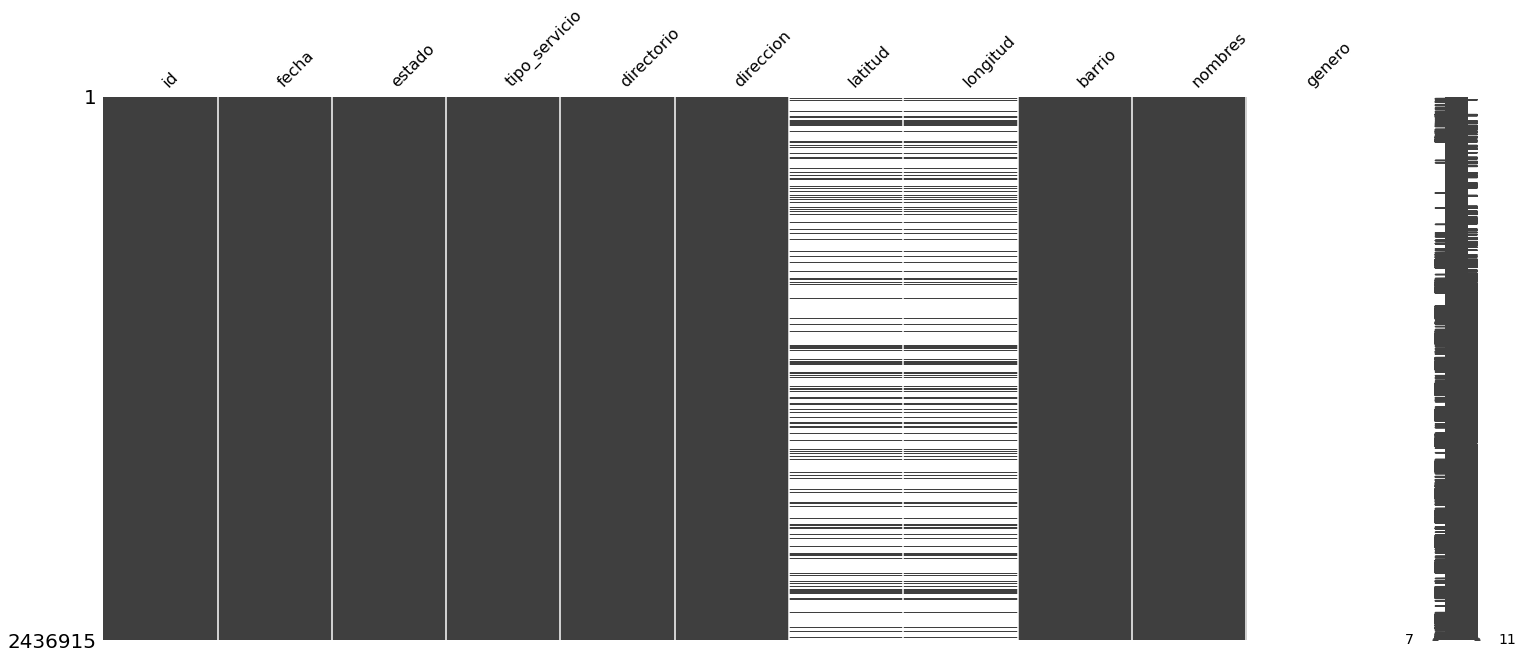

In [46]:
if len(df_taxisrcp[df_taxisrcp.isnull().any(axis=1)] != 0):
  missingno.matrix(df_taxisrcp)
  plt.show()

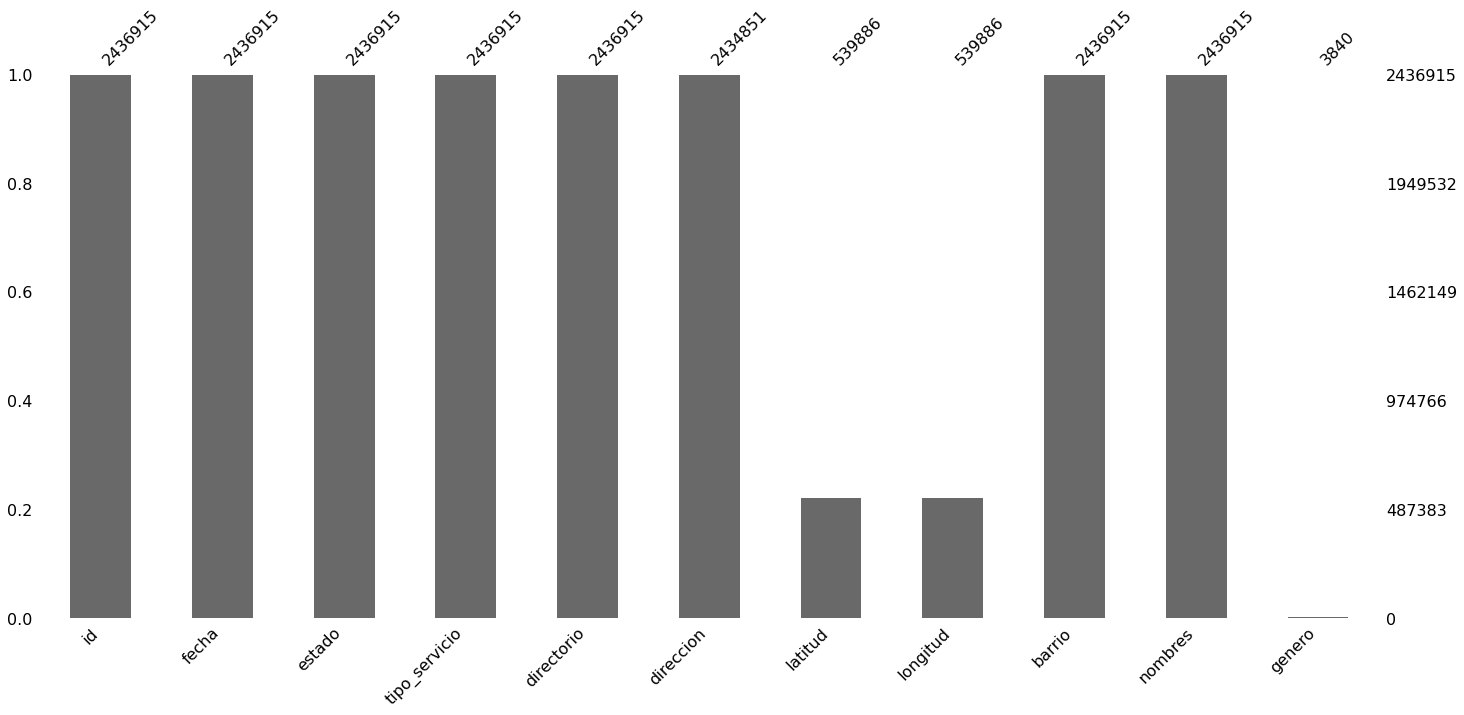

In [47]:
missingno.bar(df_taxisrcp)

In [48]:
# generate count statistics of duplicate entries
if len(df_taxisrcp[df_taxisrcp.duplicated()]) > 0:
  print("\n***Number of duplicated entries: ", len(df_taxisrcp[df_taxisrcp.duplicated()]))
  display(df_taxisrcp[df_taxisrcp.duplicated(keep=False)].sort_values(by=list(df_taxisrcp.columns)).head())
else:
  print("\nNo duplicated entries found")



No duplicated entries found


In [31]:
df_taxisrcp[df_taxisrcp.barrio.isna()]

,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero


Drop rows with direccion values null

In [ ]:
#df_taxisrcp.dropna(subset=['direccion'],inplace=True)

In [49]:
df_taxisrcp.isna().sum()

id                     0
fecha                  0
estado                 0
tipo_servicio          0
directorio             0
direccion           2064
latitud          1897029
longitud         1897029
barrio                 0
nombres                0
genero           2433075
dtype: int64

In [ ]:
df.shape

(2434851, 11)

In [50]:
df_latlon = df_taxisrcp.dropna(subset=['latitud','longitud'])


In [ ]:
df_latlon.isna().sum()

id                    0
fecha                 0
estado                0
tipo_servicio         0
directorio            0
direccion             0
latitud               0
longitud              0
barrio                0
nombres               0
genero           537145
dtype: int64

In [ ]:
df_latlon.shape

(539886, 11)

# **Detecting outliers**

In [34]:
# Function to create a Geodataframe. This code was taken from Geospatial-Data-Science-Quick-Start-Guide book
def create_gdf(df, lat, lon):
  """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
  crs = {'init': 'epsg:4326'}
  geometry = [Point(xy) for xy in zip(df[lon], df[lat])]
  gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
  return gdf



In [36]:
taxi_gdf = create_gdf(df_latlon, 'latitud', 'longitud')
taxi_gdf.head()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero,geometry
0,1684494,2019-06-15,Confirmada fuera de tiempo,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.286333,Las Margaritas,nan,NaN,POINT (-77.28633 1.22038)
13,1684554,2019-06-15,Confirmada fuera de tiempo,SC,7367325,Carrera 35 # 16 B - ED. ARADAS,1.216537,-77.291056,Parana,nan,NaN,POINT (-77.29106 1.21654)
16,1684557,2019-06-15,Confirmada fuera de tiempo,SC,3174131309,Manzana i cs 12b La Lomita,1.207778,-77.277222,La Lomita,nan,NaN,POINT (-77.27722 1.20778)
20,1684566,2019-06-15,Confirmada fuera de tiempo,SC,39,Carrera 39 # 19 - 29 MURANO 39,1.198642,-77.276898,Palermo,nan,NaN,POINT (-77.27690 1.19864)
25,1684578,2019-06-15,Confirmada fuera de tiempo,SC,388,Calle 9 # 40 - 04 ED ATURES,1.201020,-77.279882,Mariluz III,nan,NaN,POINT (-77.27988 1.20102)


In [38]:
taxi_gdf[taxi_gdf.barrio.notnull()]

,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero,geometry
0,1684494,2019-06-15,Confirmada fuera de tiempo,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.286333,Las Margaritas,nan,NaN,POINT (-77.28633 1.22038)
13,1684554,2019-06-15,Confirmada fuera de tiempo,SC,7367325,Carrera 35 # 16 B - ED. ARADAS,1.216537,-77.291056,Parana,nan,NaN,POINT (-77.29106 1.21654)
16,1684557,2019-06-15,Confirmada fuera de tiempo,SC,3174131309,Manzana i cs 12b La Lomita,1.207778,-77.277222,La Lomita,nan,NaN,POINT (-77.27722 1.20778)
20,1684566,2019-06-15,Confirmada fuera de tiempo,SC,39,Carrera 39 # 19 - 29 MURANO 39,1.198642,-77.276898,Palermo,nan,NaN,POINT (-77.27690 1.19864)
25,1684578,2019-06-15,Confirmada fuera de tiempo,SC,388,Calle 9 # 40 - 04 ED ATURES,1.201020,-77.279882,Mariluz III,nan,NaN,POINT (-77.27988 1.20102)
...,...,...,...,...,...,...,...,...,...,...,...,...
2436853,1683152,2019-06-14,Generada,SC,3162766899,Carrera 39 B # 7 - 10 Mariluz III,1.218353,-77.293639,Mariluz III,nan,NaN,POINT (-77.29364 1.21835)
2436858,1683310,2019-06-14,Confirmada,SC,7368481,Manzana R cs 3 Ciudad Real,1.207778,-77.277222,Ciudad Real,nan,NaN,POINT (-77.27722 1.20778)
2436880,1683727,2019-06-14,Confirmada,SC,3182712065,Manzana 9 cs 1 Los Laureles,1.207778,-77.277222,Los Laureles,nan,NaN,POINT (-77.27722 1.20778)
2436883,1683784,2019-06-14,Confirmada fuera de tiempo,SC,7201027,Manzana F cs 01 Las Violetas II,18.985209,-98.185129,Las Violetas II,nan,NaN,POINT (-98.18513 18.98521)


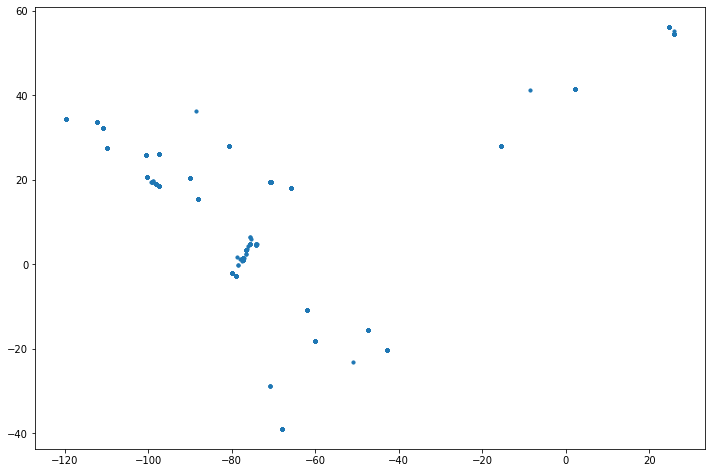

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
taxi_gdf.plot(markersize=10, ax=ax);

In [ ]:
coords = taxi_gdf[['latitud', 'longitud']]
coords[:5]

,latitud,longitud
0,1.220376,-77.286333
13,1.216537,-77.291056
16,1.207778,-77.277222
20,1.198642,-77.276898
25,1.201020,-77.279882


In [ ]:
# Get labels of each cluster 
_, labels  = dbscan(taxi_gdf[['latitud', 'longitud']], eps=0.1, min_samples=10)

In [ ]:
# Create a labels dataframe with the index of the dataset
labels_df = pd.DataFrame(labels, index=taxi_gdf.index, columns=['cluster'])
labels_df.head()

NameError: ignored

In [ ]:
labels_df.groupby('cluster').size()

# **Categorical data analysis**

In [51]:
df_taxisrcp.select_dtypes(include=['category']).nunique()

estado           5
tipo_servicio    4
genero           2
dtype: int64

In [52]:
columns = df_taxisrcp.select_dtypes(include=[ 'category']).columns
for col in columns:
    print("Unique values of " + col)
    print(df_taxisrcp[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"}))
    print("")

Unique values of estado
                       estado   Count
0                  Confirmada  944320
1  Confirmada fuera de tiempo  655325
2                      Activa  434496
3                    Generada  383918
4                   Cancelada   18856

Unique values of tipo_servicio
  tipo_servicio    Count
0            SC  2434826
1           SEU     1714
2           SEA      339
3           SEI       36

Unique values of genero
  genero  Count
0      M   3743
1      F     97



Estado


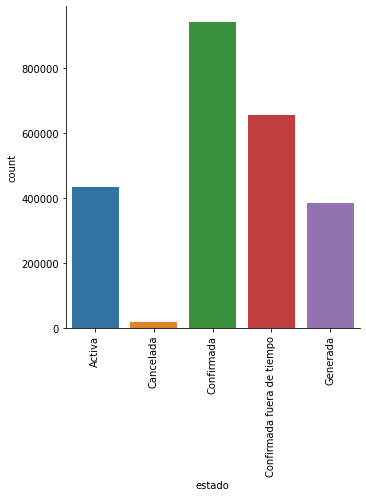

In [53]:
print('Estado')
fig = sns.catplot(x='estado', kind="count", data=df_taxisrcp)
fig.set_xticklabels(rotation=90)
plt.show()  
    

Distribution of estado data


<Figure size 1440x720 with 0 Axes>

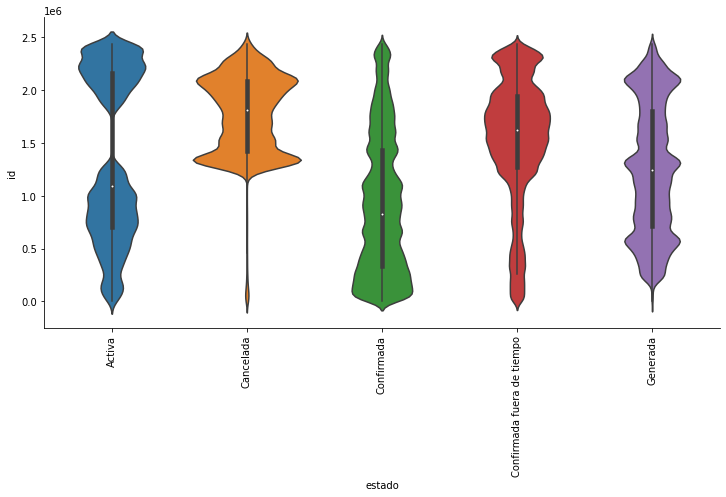

In [54]:
print("Distribution of estado data")
figure = plt.figure(figsize=(20, 10))
fig = sns.catplot(x='estado', y='id', kind='violin', data=df_taxisrcp, height=5, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

tipo_servicio


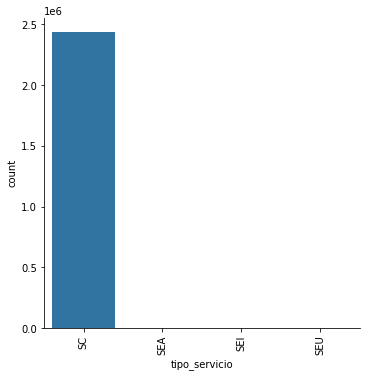

In [ ]:
print('tipo_servicio')
fig = sns.catplot(x='tipo_servicio', kind="count", data=df_taxisrcp)
fig.set_xticklabels(rotation=90)
plt.show()

Distribution of tipo_servicio data


<Figure size 1440x720 with 0 Axes>

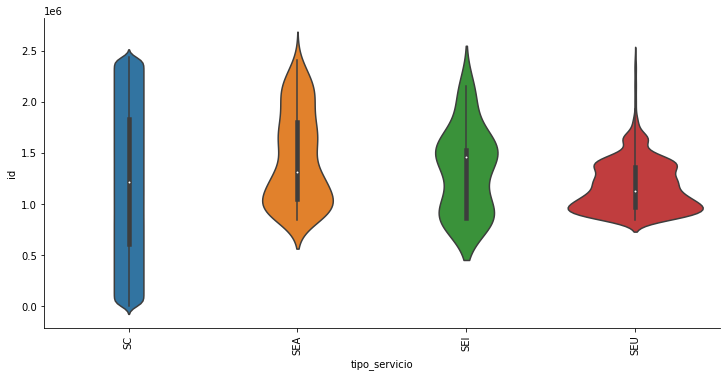

In [ ]:
print("Distribution of tipo_servicio data")
figure = plt.figure(figsize=(20, 10))
fig = sns.catplot(x='tipo_servicio', y='id', kind='violin', data=df_taxisrcp, height=5, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

genero


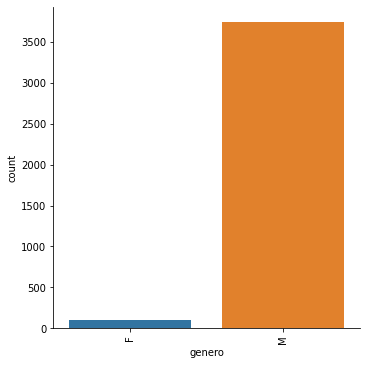

In [ ]:
print('genero')
fig = sns.catplot(x='genero', kind="count", data=df_taxisrcp)
fig.set_xticklabels(rotation=90)
plt.show()

Distribution of genero data


<Figure size 1440x720 with 0 Axes>

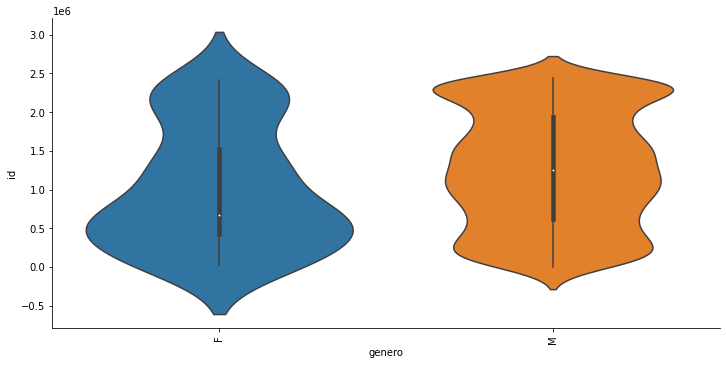

In [ ]:
print("Distribution of genero data")
figure = plt.figure(figsize=(20, 10))
fig = sns.catplot(x='genero', y='id', kind='violin', data=df_taxisrcp, height=5, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

In [55]:
df_geo = df_taxisrcp[df_taxisrcp['latitud'].notnull() & df_taxisrcp['latitud'].notnull()]

df_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539886 entries, 0 to 2436891
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             539886 non-null  int64         
 1   fecha          539886 non-null  datetime64[ns]
 2   estado         539886 non-null  category      
 3   tipo_servicio  539886 non-null  category      
 4   directorio     539886 non-null  object        
 5   direccion      539886 non-null  object        
 6   latitud        539886 non-null  float64       
 7   longitud       539886 non-null  float64       
 8   barrio         539886 non-null  object        
 9   nombres        539886 non-null  object        
 10  genero         2741 non-null    category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 38.6+ MB


In [ ]:
pasto_latitude, pasto_longitude = 1.21361,-77.28111

# define the world map centered around pasto COlombia with a higher zoom level width=550,height=550,
pasto_map = folium.Map(location=[pasto_latitude, pasto_longitude], zoom_start=8)
icon_taxi = plugins.BeautifyIcon(
    icon='taxi',
    border_color='#b3334f',
    text_color='#b3334f',icon_shape= 'marker')

def plotMarket(point):
  folium.Marker(
      location=[point.latitud, point.longitud],
      popup=point.direccion,
      icon=icon_taxi
  ).add_to(pasto_map)

df_geo.apply(plotMarket, axis = 1)
# display world map
pasto_map

In [ ]:
df_geo.head(20)

,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero
0,1684494,2019-06-15,Confirmada fuera de tiempo,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.286333,Las Margaritas,nan,NaN
13,1684554,2019-06-15,Confirmada fuera de tiempo,SC,7367325,Carrera 35 # 16 B - ED. ARADAS,1.216537,-77.291056,Parana,nan,NaN
16,1684557,2019-06-15,Confirmada fuera de tiempo,SC,3174131309,Manzana i cs 12b La Lomita,1.207778,-77.277222,La Lomita,nan,NaN
20,1684566,2019-06-15,Confirmada fuera de tiempo,SC,39,Carrera 39 # 19 - 29 MURANO 39,1.198642,-77.276898,Palermo,nan,NaN
25,1684578,2019-06-15,Confirmada fuera de tiempo,SC,388,Calle 9 # 40 - 04 ED ATURES,1.201020,-77.279882,Mariluz III,nan,NaN
28,1684581,2019-06-15,Confirmada fuera de tiempo,SC,7316085,KR 43 16C 25 REFUGIO VALLE DE ATRIZ ♠♦,1.224355,-77.290301,nan,nan,NaN
47,1684684,2019-06-15,Confirmada fuera de tiempo,SC,1320,Carrera 40 A # 20 - 120 RINCON VALLE DE ATRIZ,1.218298,-77.294162,Valle De Atriz,nan,NaN
54,1684723,2019-06-15,Confirmada,SC,1310,Carrera 35 16 B 75 ALTOS DE PARANA,1.216674,-77.290930,Parana,nan,NaN
72,1684794,2019-06-15,Confirmada fuera de tiempo,SC,1309,Carrera 34 # 16 - 68 ED SALERNO,1.220701,-77.285347,Parana,nan,NaN
81,1684822,2019-06-15,Confirmada fuera de tiempo,SC,7228922,Calle 18 B # 42 - 45 JARDÍN DE ATRIZ,1.227194,-77.287422,Valle De Atriz,nan,NaN


In [39]:
geolocator = Nominatim(user_agent="taxissasprj")
location = geolocator.geocode("REFUGIO VALLE DE ATRIZ")
print(location)

None


In [40]:
result = geocode("REFUGIO VALLE DE ATRIZ", provider="nominatim")
result

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


TypeError: ignored